In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-dataset/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-dataset/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-dataset/test.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Table Of Contents

-[Importing Libraries](#Importing-Libraries)

-[Data Loading](#Data-Loading)

-[EDA (Exploratory Data Analysis)](#EDA)

-[Imputation](#Imputation)

-[Data Preprocessing and Pipeline](#Data-Preprocessing-and-Pipeline)

-[Train-Test Split](#Train-Test-Split)

-[Feature Engineering](#Feature-Engineering)

-[Data Preprocessing and Pipeline](#Data-Preprocessing-and-Pipeline)

-[Model Training and Hyperparamter Tuning](#Model-Training)

-[Model Evaluation](#Model-Evaluation)

-[Prediction on Test Dataset](#Prediction-on-Test-Dataset)

-[Creating Submission File](#Creating-Submission-File)

# Importing Libraries


In [2]:
#Importing all neccessary libraries required in this notebook:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score, classification_report, confusion_matrix

# Data Loading

In [3]:
#Loading the training and test datasets:

train_df = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
test_df = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

# EDA

In [4]:
#Let's check the first few rows of each dataset

#Checking for training dataset:
print("Training Data Overview:")
print(train_df.head())

#Checking for test dataset:
print("\nTest Data Overview:")
print(test_df.head())

Training Data Overview:
    ID  RecipeNumber  RecipeCode                              RecipeName  \
0   70            71       12259  Banana Bars with Cream Cheese Frosting   
1   72            88        8202                        Simple Taco Soup   
2  458             3        2832                       Cheeseburger Soup   
3    7            50      100276               Grilled Huli Huli Chicken   
4   60            12       19731                        Cauliflower Soup   

                     CommentID                         UserID        UserName  \
0   sp_aUSaElGf_12259_c_149978  u_1oKVaBmiEKwAFyiHrDLoWpbel0J   misscoffeepot   
1    sp_aUSaElGf_8202_c_310332  u_1oKZeRIXYzGNhGW8OMR3O4lX1ih  MichelleMalone   
2    sp_aUSaElGf_2832_c_206522  u_1oKYHUtdaD48KJCDYq5wfpAUxWz       jeannem32   
3  sp_aUSaElGf_100276_c_434088  u_1oKZCQcKQZdQhDVBS7oISc216VA           ds422   
4   sp_aUSaElGf_19731_c_387011  u_1oKd4sudZQPgu6YALiC7bW7mKMs     SusanHoward   

   UserReputation  CreationTimes

In [5]:
#The size of the training and test datasets:

print(f"The shape of the training dataset is: {train_df.shape}")
print(f"The shape of the test dataset is: {test_df.shape}")

The shape of the training dataset is: (13636, 15)
The shape of the test dataset is: (4546, 14)


In [6]:
#Summary of training dataset:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [7]:
#Descriptive Statistics for training dataset:

train_df.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


#### Insights

From the provided data, we can infer several insights:

*Recipe Number Distribution*: The mean recipe number is approximately 38.62, with a standard deviation of 29.67. This indicates that the recipes are spread out across a range of numbers, with some recipes being more frequently referenced than others.

*User Reputation*: The mean user reputation is approximately 21785.99, with a standard deviation of 23883.19. This suggests that there is a wide range of user reputations among those interacting with the recipes.

*Creation Timestamps*: The minimum creation timestamp indicates when the earliest recipe was created. The mean creation timestamp is around 1.623713e+09, indicating when the majority of recipes were created. The maximum creation timestamp indicates the latest time a recipe was created. This information could be useful for analyzing trends over time.

*Engagement Metrics*:

- The mean reply count is approximately 0.01452, with a standard deviation of 0.13732, indicating that most recipes receive very few replies.
- The mean thumbs up count is approximately 1.098, with a standard deviation of 4.166. This suggests that while some recipes receive a significant number of thumbs up, many receive very few.
- The mean thumbs down count is approximately 0.5437, with a standard deviation of 3.2657. Similar to thumbs up, this suggests variability in the reception of recipes.
- The mean rating is approximately 4.29, indicating that, on average, recipes are well-received. However, the standard deviation of 1.54 suggests some variability in ratings.
- The mean best score is approximately 153.13, with a standard deviation of 140.99, indicating variability in the quality or popularity of recipes.

*Outliers*:

- The maximum user reputation, creation timestamp, reply count, thumbs up count, thumbs down count, rating, and best score values are significantly higher than their respective means. These outliers could represent particularly popular recipes or users with exceptionally high reputations.
- Distribution Percentiles: The quartiles (25th, 50th, and 75th percentiles) provide insight into the distribution of the data and help identify any skewness. For example, the 75th percentile values for user reputation and creation timestamp are significantly higher than their respective means, indicating potential right skewness in the data distribution.

In [8]:
#Checking for Unique Values:

for i in train_df.columns:
    print(f"The number of unique values in {i} are {train_df[i].nunique()}")

The number of unique values in ID are 701
The number of unique values in RecipeNumber are 100
The number of unique values in RecipeCode are 100
The number of unique values in RecipeName are 100
The number of unique values in CommentID are 13636
The number of unique values in UserID are 10783
The number of unique values in UserName are 10620
The number of unique values in UserReputation are 20
The number of unique values in CreationTimestamp are 2422
The number of unique values in ReplyCount are 4
The number of unique values in ThumbsUpCount are 57
The number of unique values in ThumbsDownCount are 51
The number of unique values in Rating are 6
The number of unique values in BestScore are 525
The number of unique values in Recipe_Review are 13370


In [9]:
#Listing the Unique Values:

for i in train_df.columns:
    print(f"{i} has {train_df[i].value_counts()} different values")
    print("------------------------------------------------------")

ID has ID
19     85
25     83
90     82
69     82
71     81
       ..
552     1
706     1
572     1
608     1
675     1
Name: count, Length: 701, dtype: int64 different values
------------------------------------------------------
RecipeNumber has RecipeNumber
3     553
1     483
2     372
9     313
13    307
     ... 
54     68
97     65
91     64
72     64
61     19
Name: count, Length: 100, dtype: int64 different values
------------------------------------------------------
RecipeCode has RecipeCode
2832     553
14299    483
3309     372
42083    313
32480    307
        ... 
35766     68
34347     65
3683      64
1821      64
17022     19
Name: count, Length: 100, dtype: int64 different values
------------------------------------------------------
RecipeName has RecipeName
Cheeseburger Soup             553
Creamy White Chili            483
Best Ever Banana Bread        372
Enchilada Casser-Ole!         313
Basic Homemade Bread          307
                             ... 
Cheesebu

In [10]:
#Let's segregate numerical and categorical columns to perform EDA

#Categorical Columns:
cat_col = [col for col in train_df.columns if train_df[col].dtype == 'object' or train_df[col].dtype.name == 'category']

#Numerical Columns:
num_col = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]

#Printing the number of numerical and categorical columns:
print(f"The number of numerical columns present: {len(num_col)}")
print(f"The number of categorical columns present: {len(cat_col)}")

#Printing the names of those columns segregated into numerical and categorical:
categorical_cols = []
numerical_cols = []

for col in train_df.columns:
    if col in num_col:
        numerical_cols.append(col)
    else:
        categorical_cols.append(col)

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

The number of numerical columns present: 10
The number of categorical columns present: 5
Categorical columns: ['RecipeName', 'CommentID', 'UserID', 'UserName', 'Recipe_Review']
Numerical columns: ['ID', 'RecipeNumber', 'RecipeCode', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore']


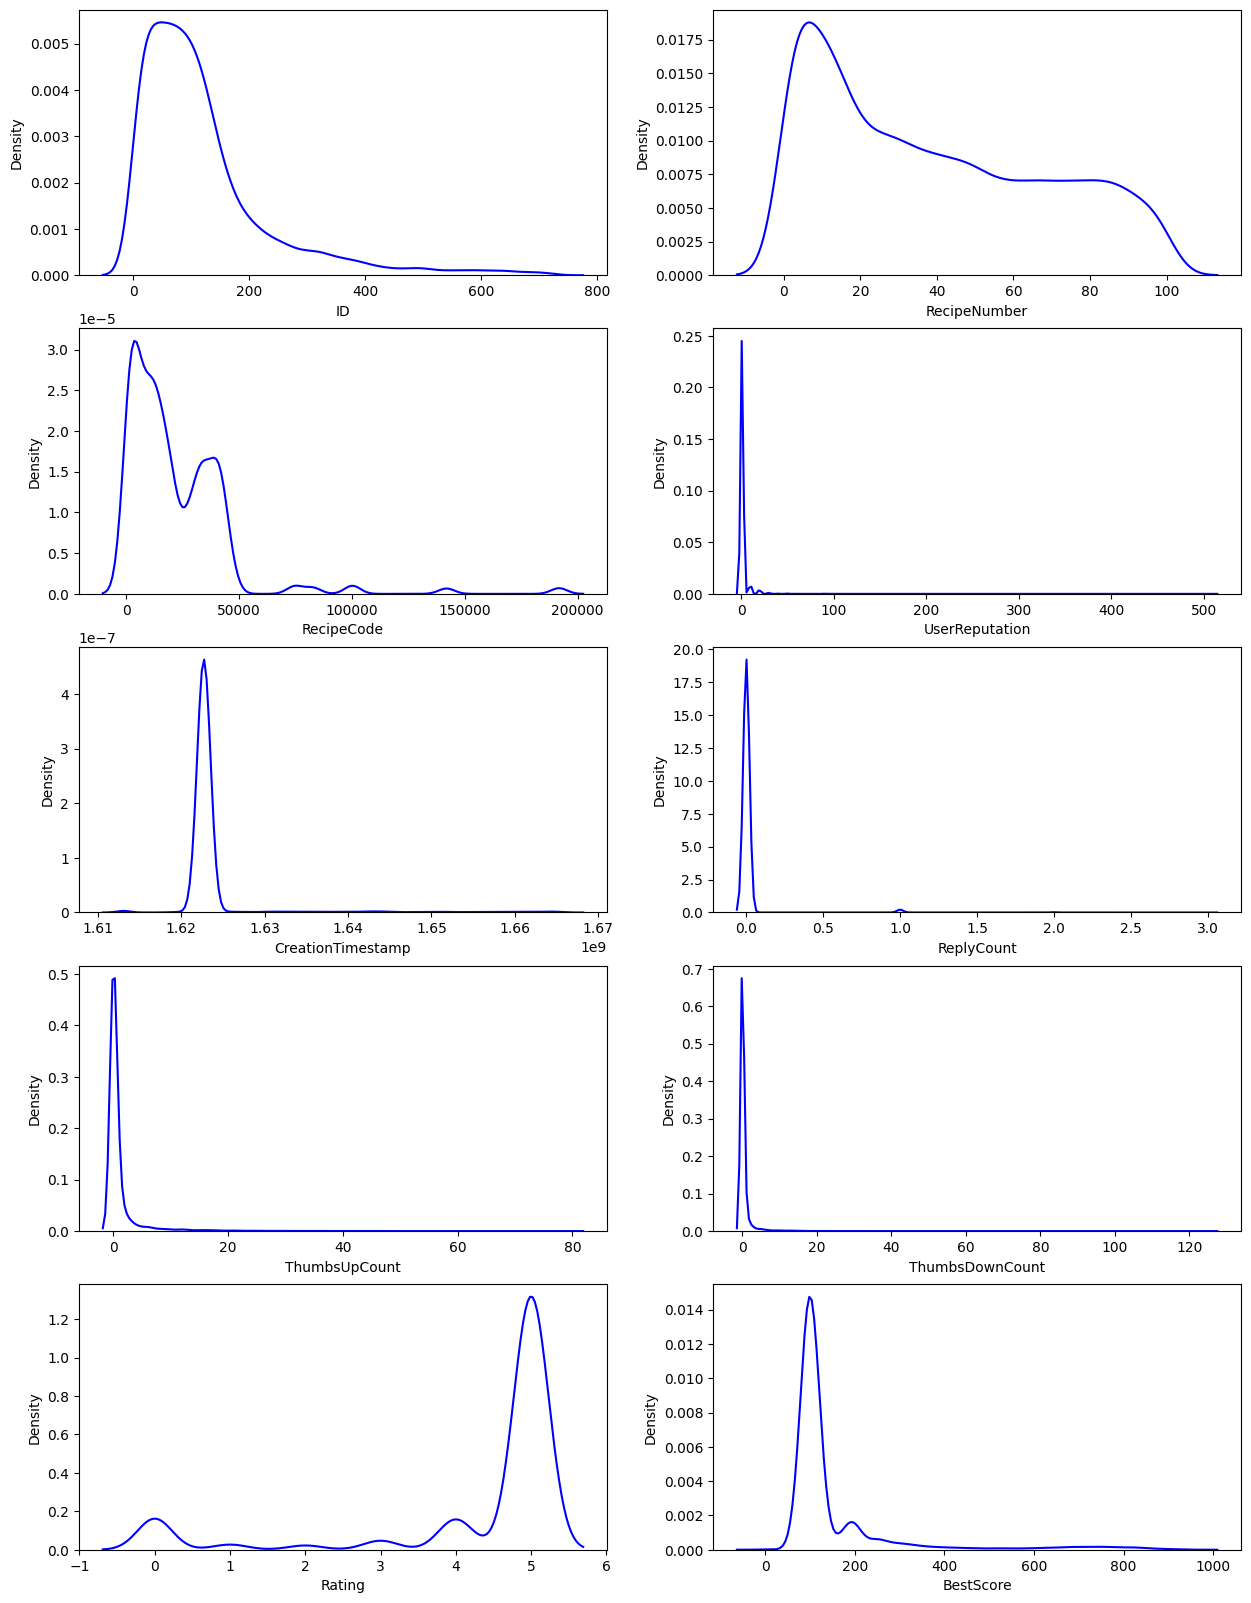

In [ ]:
#Now performing Univariate Analysis for Numerical Columns: 

#To remove warnings from the output display:     
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,20))                           #to define figure size
plt.title("Univariate Analysis", fontsize=20)         #to give title to the figure

num_row = 5                                           #to define number of rows in the figure
num_column = 2                                        #to define number of columns in the figure

for j in range(0, len(num_col)):
    plt.subplot(num_row,num_column,j+1)
    sns.kdeplot(x=train_df[num_col[j]], color="blue")
    plt.xlabel(num_col[j])

#### Insights

In the above graphs:

- The x-axis represents the column names.
- The y-axis represents “Density,” which indicates the likelihood of data points occurring at column values.
- The blue line represents the density of data points across the range of columns.

From the above graphs, the following observations can be made for each column:

- *ID*: The distribution is symmetric and appears to follow a normal distribution (bell-shaped curve) centered around an ID value of approximately 100.

- *RecipeNumber*: The distribution appears to follow a normal distribution (bell-shaped curve) centered around a RecipeNumber value of approximately 10-20. As the RecipeNumber increases or decreases from this peak, the density of data points diminishes. The distribution is symmetric, suggesting that the it may be normally distributed.

- *RecipeCode*: The distribution has a prominent peak near zero RecipeCode. There is another smaller peak around RecipeCode 50,000. As RecipeCode increases beyond these peaks, the density decreases. These observations suggest that many recipes have low RecipeCode values and the distribution may be skewed or multimodal.

- *UserReputation*: The density sharply peaks at zero UserReputation. Most users have low reputation scores. The distribution quickly tapers off as UserReputation increases. This suggests taht a significant number of users have no reputation (score of zero).

- *CreationTimestamp*: The distribution has a prominent peak near a specific timestamp (approximately 1.63e9). This peak suggests that a significant number of events were created around that specific time. As CreationTimestamp deviates from this peak, the density decreases.

- *ReplyCount*: The density sharply peaks at zero ReplyCount. Most recipess have no replies. As ReplyCount increases, the density decreases rapidly. This implies that a large proportion of recipes receive no replies.

- *ThumbsUpCount*: The density sharply peaks at zero ThumbsUpCount. Most items have received no thumbs-up. As ThumbsUpCount increases, the density decreases rapidly. This shows that a significant number of items have not been positively rated.

- *ThumbsDownCount*: Similar to ThumbsUpCount, the density sharply peaks at zero ThumbsDownCount. Most items have received no thumbs-down. As ThumbsDownCount increases, the density decreases rapidly. A large proportion of items have not been negatively rated.

- *Rating*: The density sharply peaks around a rating of 5. Most items have received a rating close to 5. As the rating deviates from this peak, the density decreases. A significant number of items are highly rated.

- *BestScore*: The density sharply peaks around a best score of approximately 200. Most items have a best score close to 200. As the best score increases beyond this peak, the density decreases rapidly.

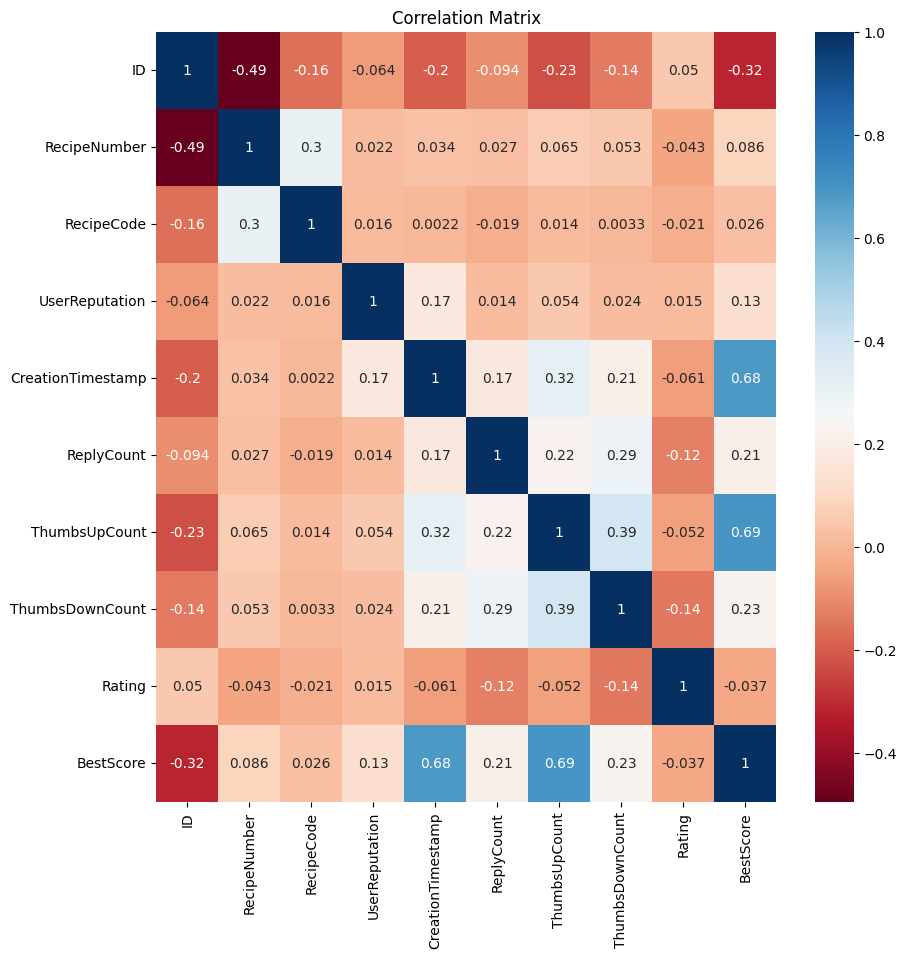

In [ ]:
#For Numerical Columns a Correlation Matrix can also be checked:

corr_mat = train_df.corr(numeric_only=True)
plt.figure(figsize=(10,10))
mask = np.triu(corr_mat)
sns.heatmap(corr_mat, annot=True, cmap='RdBu')
plt.title("Correlation Matrix")
plt.show()

#### Insights

From the above Correlation-Matrix Heatmap, we can observe that the columns which have a good correlation between each other in comparison to others are:

- *ID*: Rating
- *RecipeNumber*: RecipeCode, BestScore
- *RecipeCode*: RecipeNumber, UserReputation
- *CreationTimestamp*: ThumbsUpCount, ThumbsDownCount, BestScore, hour
- *ReplyCount*: ThumbsDownCount, ThumbsUpCount, BestScore, CreationTimestamp
- *ThumbsUpCount*: CreationTimestamp, ReplyCount, ThumbsDownCount, BestScore, hour
- *ThumbsDownCount*: CreationTimestamp, ReplyCount, ThumbsUpCount, BestScore
- *Rating*: ID, UserReputation
- *BestScore*: CreationTimestamp, ThumbsUpCount, hour
- *hour*: CreationTimestamp, ThumbsUpCount, BestScore

In [13]:
#Extracting Time Features from CreationTimestamp:

train_df['Datetime'] = pd.to_datetime(train_df['CreationTimestamp'],unit='s')
train_df['Month'] = train_df['Datetime'].dt.strftime("%B")
train_df['WeekDay'] = train_df['Datetime'].dt.strftime("%A")
train_df['hour'] = train_df['Datetime'].dt.hour

train_df

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,Datetime,Month,WeekDay,hour
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...,2021-06-03 10:44:38,June,Thursday,10
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...,2021-06-03 10:57:32,June,Thursday,10
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...,2021-06-03 10:49:17,June,Thursday,10
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,2021-06-02 15:48:19,June,Wednesday,15
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,2021-06-03 11:04:20,June,Thursday,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13631,115,98,11767,Quick Cream of Mushroom Soup,sp_aUSaElGf_11767_c_127710,u_1oKVbHjirkAIWwTjbt9dWyqENo2,elbay,1,1622716969,0,0,0,5,100,Delicious!! Very easy to make! One minor chang...,2021-06-03 10:42:49,June,Thursday,10
13632,372,6,21444,Favorite Chicken Potpie,sp_aUSaElGf_21444_c_196030,u_1oKXoBnyJ2ocquNYwAhs19LMSrA,PauletteInhofe,1,1622717329,0,0,0,5,100,I made this pie for my family and they loved i...,2021-06-03 10:48:49,June,Thursday,10
13633,87,37,20170,Taco Lasagna,sp_aUSaElGf_20170_c_359338,u_1oKbGr5o9tj0mQl1rkVqzWnE481,Barbaralarkin,1,1622718089,0,0,0,5,100,Very tasty!,2021-06-03 11:01:29,June,Thursday,11
13634,48,63,24886,Chicken and Dumplings,sp_aUSaElGf_24886_c_175514,u_1oKWD7Dqjmc0oYHdW8Vm3fzhxJW,SammyPrissy,1,1622717192,0,0,0,5,100,I have made this numerous times. It&#39;s so ...,2021-06-03 10:46:32,June,Thursday,10


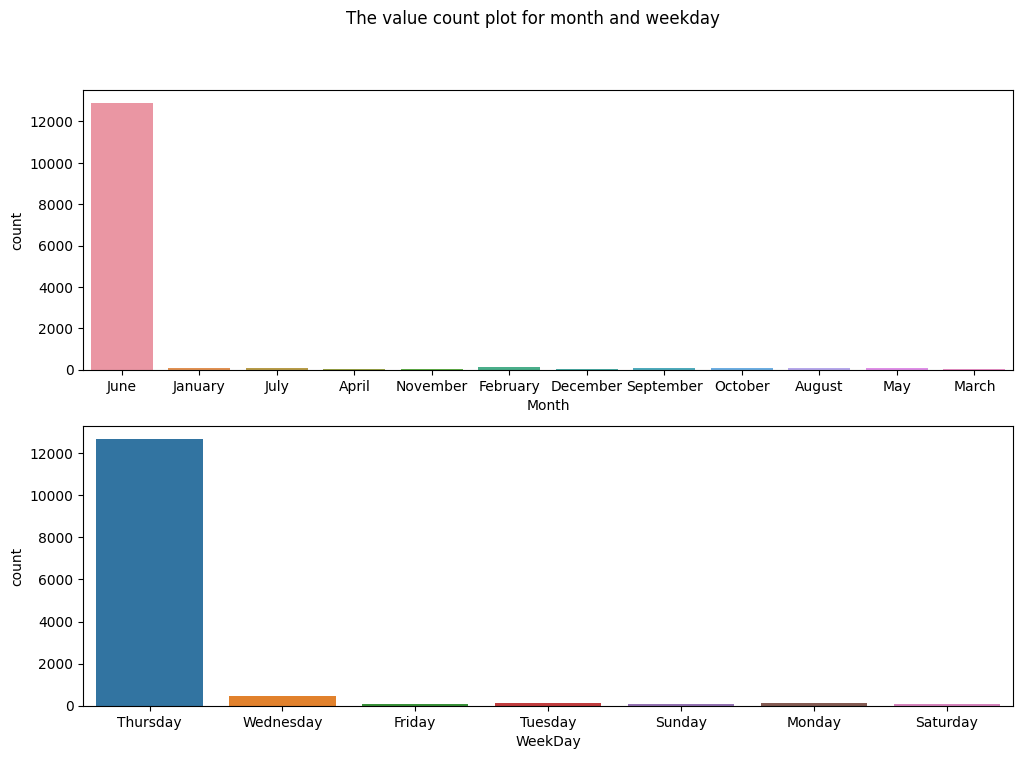

In [14]:
#We can visualize data in form of Value Count Plots. Two such examples of Value Count Plots are given below:

#Value Count for Month:
train_df['Month'].value_counts()

#Value Count for WeekDay:
train_df['WeekDay'].value_counts()

#Value Count for Hour:
train_df['hour'].value_counts()

#Plotting:
arr = ['Month', 'WeekDay']
plt.figure(figsize=(12,8))
plt.suptitle("The value count plot for month and weekday")

for i in range(len(arr)):
    plt.subplot(2,1,i+1)
    sns.countplot(x=train_df[arr[i]])
    plt.xlabel(arr[i])

#### Insights

The plots show that the month of June among months and Thursday among all weekdays, have a significantly higher count compared to other months and weekdays respectively.

In [15]:
#To get the count of values in Rating column:

train_df.Rating.value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

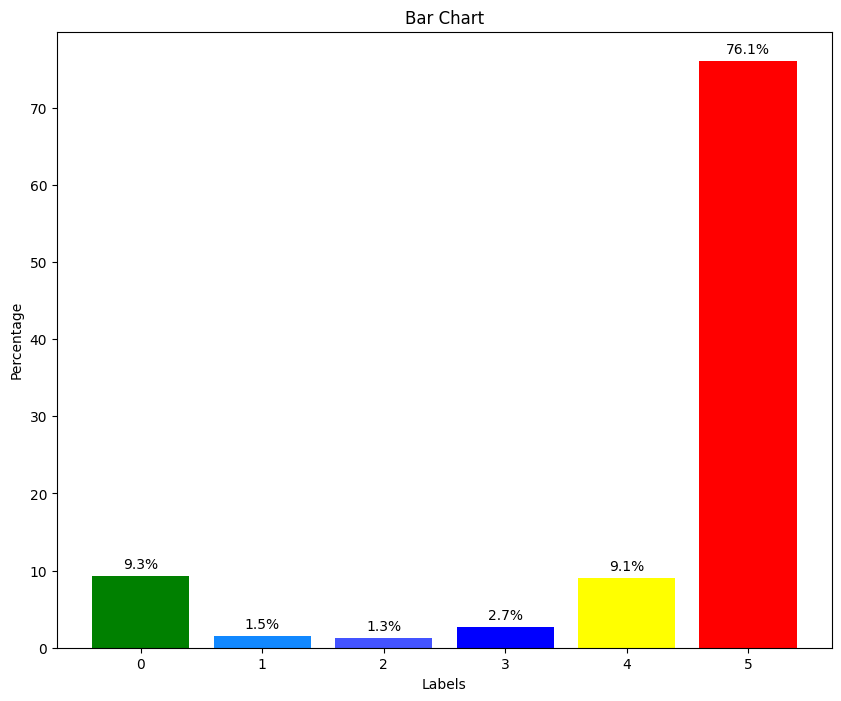

In [16]:
#Visualizing the distribution of the Target Variable i.e. 'Rating':

labels = [5, 0, 4, 3, 1, 2]                                      #From the output of the last code cell
value_counts = train_df['Rating'].value_counts(normalize=True)
percentages = [value_counts[label] * 100 if label in value_counts.index else 0 for label in labels] 

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red', 'green', 'yellow', 'blue', '#1188ff', '#4353ff']

bars = ax.bar(labels, percentages, color=colors)

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.annotate(f'{percentage:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_title('Bar Chart')

plt.show()

#### Insights

From the above plot it is evident that most of the recipes have been rated 5, and it can also be concluded that the data is very imbalanced.

# Imputation

## (Null Value Treatment)

In [17]:
#Checking for Missing values:

#For training dataset:
print("\nMissing values in training data:")
print(train_df.isnull().sum())

#For test dataset:
print("\nMissing values in test data:")
print(test_df.isnull().sum())


Missing values in training data:
ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
Datetime             0
Month                0
WeekDay              0
hour                 0
dtype: int64

Missing values in test data:
ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
dtype: int64


#### Insights

From the provided information about missing values in the above output:

*Training Data*: There are missing values in the column "Recipe_Review," with 2 missing values. This suggests that for two entries in the training data, there are no reviews or comments associated with the recipes.

*Test Data*: There are no missing values in any of the columns in the test data.

In [18]:
#Replacing missing values in the 'Recipe_Review' column with empty strings:

train_df['Recipe_Review'].fillna('', inplace=True)

# Train-test Split

In [19]:
#Separating Features (X) and Target Variable (y):

X = train_df.drop(columns=['Rating'])
y = train_df['Rating']

In [20]:
#Splitting the data into Training and Validation sets:

X_train,X_valid,Y_train,Y_valid = train_test_split(X, y , test_size=0.2, random_state=1) 

In [21]:
#Displaying X_train data for reference:

X_train

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review,Datetime,Month,WeekDay,hour
3906,137,14,7178,Zucchini Cupcake,sp_aUSaElGf_7178_c_147399,u_1oKWbN1RsIJjMsGyNXFAxhWpq8X,kozy2,1,1622717076,0,0,0,100,"great recipe, made these for party,there were...",2021-06-03 10:44:36,June,Thursday,10
10518,33,22,1081,Baked Spaghetti,sp_aUSaElGf_1081_c_247739,u_1oKXws4nyWZ9GHoZ4FnuuYuqXlO,NerissaPerissa,1,1622717551,0,0,0,100,My entire family Loves this recipe. It is grea...,2021-06-03 10:52:31,June,Thursday,10
10939,145,52,27434,Asian Chicken Thighs,sp_aUSaElGf_27434_c_124715,u_1oKVtSLtNSGfbPNyPT9pAFiVffo,lavidalori,1,1622716963,0,0,0,100,Delicious and very easy to prepare! I used bo...,2021-06-03 10:42:43,June,Thursday,10
6243,21,80,39581,Homemade Peanut Butter Cups,sp_aUSaElGf_39581_c_190582,u_1oKViLBdgWJi2cCnhuiUvDbqGTZ,DDPLoeches,10,1622717263,0,0,0,100,I made these with gluten-free ingredients for ...,2021-06-03 10:47:43,June,Thursday,10
234,83,2,3309,Best Ever Banana Bread,sp_aUSaElGf_3309_c_389562,u_1oKcygq4qTggoOAbeKDUyZEhIMJ,BobbiSalafie,1,1622718282,0,0,0,100,I added 1/2 cup soaked raisins. Mmmm,2021-06-03 11:04:42,June,Thursday,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,207,13,32480,Basic Homemade Bread,sp_aUSaElGf_32480_c_409714,u_1oKdgVb9dskMKBvlN8pAabLiIJX,JohnFitzpatrick,1,1622718356,0,0,0,100,Question for the author (or a successful user ...,2021-06-03 11:05:56,June,Thursday,11
5192,118,55,38550,Special Banana Nut Bread,sp_aUSaElGf_38550_c_178371,u_1oKXQYeGkI3eYewweC5nhWw7HZ3,twin_pat,1,1622717261,0,0,0,100,"I have tried many Banana Bread receipes, but t...",2021-06-03 10:47:41,June,Thursday,10
12172,112,23,14600,Buttery Cornbread,sp_aUSaElGf_14600_c_318591,u_1oKXItJ799TRaNZMVE5rNQyMowy,AnneMetzler,1,1622717898,0,0,0,100,This is the best cornbread I&#39;ve ever made!...,2021-06-03 10:58:18,June,Thursday,10
235,168,15,10252,Li’l Cheddar Meat Loaves,sp_aUSaElGf_10252_c_384550,u_1oKWXHQ3eWI7mD4R7CKLGJlrFB4,D Beverly,1,1622718216,0,0,0,100,Easy to make. One of my families favorites!,2021-06-03 11:03:36,June,Thursday,11


# Feature Engineering

In [23]:
#Performing Chi-Square Test to know relation between Categorical Values and Target Variable

#Here, 'Failed to Reject the Null Hypotheis' means that the column is not related to target label and, 
#Reject the Null Hypothesis' means that the column is related to the target variable

chisq_test = []

for j in cat_col:
    if chi2_contingency(pd.crosstab(train_df['Rating'], train_df[j]))[1] < 0.05:
        chisq_test.append("Reject the null hypothesis")
    else:
        chisq_test.append("Failed to Reject null hypothesis")

        
test_result = pd.DataFrame({"Feature Name": cat_col, "Result": chisq_test})
test_result.columns = ["Feature Name", "Results"]
test_result

,Feature Name,Results
0,RecipeName,Reject the null hypothesis
1,CommentID,Failed to Reject null hypothesis
2,UserID,Reject the null hypothesis
3,UserName,Reject the null hypothesis
4,Recipe_Review,Reject the null hypothesis


#### Insights

From the above Data Frame, we can say that RecipeName, UserID, UserName, and RecipeReview have a relation with Rating (target variable) while CommentID does not have any relation with Rating.

In [ ]:
#Listing out numerical, categorical and text columns which will be used for feature engineering

numerical_columns = ['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'BestScore', 'ThumbsDownCount']
categorical_columns = ['ID','RecipeNumber']   
text_columns = ['Recipe_Review']

In [24]:
#Displaying numerical columns from X_train set:

numerical_df = X_train[numerical_columns]
numerical_df

,UserReputation,ReplyCount,ThumbsUpCount,BestScore,ThumbsDownCount
3906,1,0,0,100,0
10518,1,0,0,100,0
10939,1,0,0,100,0
6243,10,0,0,100,0
234,1,0,0,100,0
...,...,...,...,...,...
905,1,0,0,100,0
5192,1,0,0,100,0
12172,1,0,0,100,0
235,1,0,0,100,0


In [25]:
#Selecting two best features from the numerical columns:

#Using chi2:
numerical_features = SelectKBest(chi2, k=2)                       
X_best = numerical_features.fit_transform(numerical_df,Y_train)
numerical_features.get_support() 

array([False, False, False,  True,  True])

#### Insights

So from the output, we realise that the best numerical features would be ThumbsUpCount and BestScore using chi2

In [26]:
#Similarly, we will display categorical columns now:

categorical_df = X_train[categorical_columns]
categorical_df

,ID,RecipeNumber
3906,137,14
10518,33,22
10939,145,52
6243,21,80
234,83,2
...,...,...
905,207,13
5192,118,55
12172,112,23
235,168,15


In [27]:
#Before, selecting best features, we will first encode our categorical values:

encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(categorical_df)

#Now, we can proceed with feature selection using f_classif:

cat_features = SelectKBest(f_classif, k=2)
X_best = cat_features.fit_transform(X_encoded, Y_train)
cat_features.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

# Data Preprocessing and Pipeline

In [28]:
#Pipeline Setup and Transformation:

numerical_pipeline = Pipeline([('feature_selection', SelectKBest(chi2, k=2)), ('scaler', RobustScaler())])
categorical_pipeline = Pipeline([('Encoding', OneHotEncoder(handle_unknown = 'ignore'))])
text_pipeline = Pipeline([('Tfidf', TfidfVectorizer())])

Transformer = ColumnTransformer([('num_pipe', numerical_pipeline, numerical_columns), ('cat_pipe', categorical_pipeline, categorical_columns)])

Transformer.fit_transform(X_train, Y_train)

<10908x775 sparse matrix of type '<class 'numpy.float64'>'
	with 25775 stored elements in Compressed Sparse Row format>

In [29]:
#Applying Transformation to Test/Validation Data:

Transformer.transform(X_valid)

<2728x775 sparse matrix of type '<class 'numpy.float64'>'
	with 6416 stored elements in Compressed Sparse Row format>

In [30]:
#Defining Train transformer and Test transformer functions:

#Train transformer:
def train_transformer(x_train, y_train, transformer, pipeline):
    x1 = transformer.fit_transform(x_train, y_train).todense()
    x2 = pipeline.fit_transform(x_train['Recipe_Review'], y_train).todense()
    x_transformed = np.concatenate((x1,x2),axis=1)
    return x_transformed

#Test transformer:
def test_transformer(x_test,transformer,pipeline):
    x1 = transformer.transform(x_test).todense()
    x2 = pipeline.transform(x_test['Recipe_Review']).todense()
    x_transformed_test = np.concatenate((x1,x2),axis=1)
    return x_transformed_test

In [31]:
#Applying train transformer function on the whole training dataset:

X_transformed_whole = train_transformer(X,y,Transformer,text_pipeline)

In [32]:
#Applying train transformer function on the train set:

X_transformed_train = train_transformer(X_train,Y_train,Transformer,text_pipeline)

In [33]:
#Applying test transformer function on the validation set:

X_transformed_valid = test_transformer(X_valid, Transformer, text_pipeline)

In [34]:
#Applying test transformer function on the test dataset:

X_transformed_test = test_transformer(test_df,Transformer,text_pipeline)

# Model Training

### 1. Model Training using XGBClassifier

#### Hyperparameter Tuning of XGBClassifier

In [35]:
# Defining XGBClassifier model:
#model1_hpt = XGBClassifier()

# Defining hyperparameters to tune:
#param_grid = {
#    'max_features': [100, 150, 200],  
#    'max_depth': [3, 5, 7, 10]}

# Performing grid search cross-validation:
#grid_search = GridSearchCV(estimator=model1_hpt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
#grid_search.fit(X_transformed, Y_train)

# Best hyperparameters found:
#print("Best hyperparameters:", grid_search.best_params_)

The best parameters are: max_features=150 and max_depth=5

#### Training the model:

In [37]:
#Getting the accuracy score by the model using best parameters:

model1 = XGBClassifier(max_features=150, max_depth=5)
model1.fit(X_transformed_train, Y_train)
accuracy = model1.score(X_transformed_valid, Y_valid)
print(f"The accuracy attained by this model is: {accuracy}")

The accuracy attained by this model is: 0.7749266862170088


In [63]:
#Training the model using best parameters:

#model1 = XGBClassifier(max_features=150, max_depth=5)
#model1.fit(X_transformed, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_features=150,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### 2. Model Training using LogisticRegression

#### Hyperparameter Tuning of LogisticRegression Classifier:

In [ ]:
# Defining logistic regression model:
#model2_hpt = LogisticRegression()

# Defining hyperparameters to tune:
#param_grid = {
#    'penalty': ['l1', 'l2'],
#    'C': [0.01, 1.15, 10],  # Regularization parameter
#    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  # Optimization algorithm
#}

# Performing grid search cross-validation:
#grid_search = GridSearchCV(estimator=model2_hpt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
#grid_search.fit(np.asarray(X_transformed), Y_train)

# Best hyperparameters found:
#print("Best hyperparameters:", grid_search.best_params_)

The best parameters are: penalty=l1, C=1.5, solver=liblinear

#### Training the model:

In [38]:
#Getting the accuracy score by the model using best parameters:

model2 = LogisticRegression(penalty='l1', C=1.15, solver='liblinear')
model2.fit(np.asarray(X_transformed_train), Y_train)
accuracy = model2.score(np.asarray(X_transformed_valid), Y_valid)
print(f"The accuracy attained by this model is: {accuracy}")

The accuracy attained by this model is: 0.7767595307917888


In [47]:
#Training the model using best parameters:

#model2 = LogisticRegression(penalty='l1', C=1.15, solver='liblinear')
#model2.fit(np.asarray(X_transformed), y)

LogisticRegression(C=1.15, penalty='l1', solver='liblinear')

### 3. Model Training using RandomForestClassifier

In [39]:
#Getting the accuracy score by the model using best parameters:

model3 = RandomForestClassifier()
model3.fit(np.asarray(X_transformed_train), Y_train)
accuracy = model3.score(np.asarray(X_transformed_valid), Y_valid)
print(f"The accuracy attained by this model is: {accuracy}")

The accuracy attained by this model is: 0.7719941348973607


In [ ]:
#Training the model using best parameters:

#model3 = RandomForestClassifier()
#model3.fit(np.asarray(X_transformed), y)

### 4. Model Training using KNeighborsClassifier

In [40]:
#Getting the accuracy score by the model using best parameters:

model4 = KNeighborsClassifier()
model4.fit(np.asarray(X_transformed_train), Y_train)
accuracy = model4.score(np.asarray(X_transformed_valid), Y_valid)
print(f"The accuracy attained by this model is: {accuracy}")

The accuracy attained by this model is: 0.7379032258064516


In [ ]:
#Training the model using best parameters:

#model4 = KNeighborsClassifier()
#model4.fit(np.asarray(X_transformed), y)

### 5. Model Training using DecisionTreeClassifier

In [41]:
#Getting the accuracy score by the model using best parameters:

model5 = DecisionTreeClassifier()
model5.fit(np.asarray(X_transformed_train), Y_train)
accuracy = model5.score(np.asarray(X_transformed_valid), Y_valid)
print(f"The accuracy attained by this model is: {accuracy}")

The accuracy attained by this model is: 0.6862170087976539


In [ ]:
#Training the model using best parameters:

#model5 = DecisionTreeClassifier()
#model5.fit(np.asarray(X_transformed), y)

### 6. Model Training using LGBMClassifier

In [ ]:
# Defining LGBM model:
#model6_hpt = LGBMClassifier()

# Defining hyperparameters to tune:
#param_grid = {
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [5, 10, 15]
#}

# Performing grid search cross-validation:
#grid_search = GridSearchCV(estimator=model6_hpt, param_grid=param_grid, cv=3, scoring='accuracy')
#grid_search.fit(np.asarray(X_transformed), Y_train)

# Best hyperparameters found:
#print("Best hyperparameters:", grid_search.best_params_)

The best parameters are: learning_rate=0.1 and max_depth=5

In [42]:
#Getting the accuracy score of the model using best hyperparameters:

model6 = LGBMClassifier(learning_rate=0.1, max_depth=5, force_row_wise=True)
model6.fit(np.asarray(X_transformed_train), Y_train)
accuracy = model6.score(np.asarray(X_transformed_valid), Y_valid)
print(f"The accuracy attained by this model is: {accuracy}")

[LightGBM] [Info] Total Bins 69988
[LightGBM] [Info] Number of data points in the train set: 10908, number of used features: 1655
[LightGBM] [Info] Start training from score -2.372639
[LightGBM] [Info] Start training from score -4.115468
[LightGBM] [Info] Start training from score -4.355609
[LightGBM] [Info] Start training from score -3.583519
[LightGBM] [Info] Start training from score -2.410720
[LightGBM] [Info] Start training from score -0.274326
The accuracy attained by this model is: 0.781891495601173


In [112]:
#Training the model:

#model6 = LGBMClassifier(force_row_wise=True)
#model6.fit(np.asarray(X_transformed),y)

[LightGBM] [Info] Total Bins 82976
[LightGBM] [Info] Number of data points in the train set: 13636, number of used features: 1858
[LightGBM] [Info] Start training from score -2.372123
[LightGBM] [Info] Start training from score -4.173361
[LightGBM] [Info] Start training from score -4.361413
[LightGBM] [Info] Start training from score -3.612386
[LightGBM] [Info] Start training from score -2.396796
[LightGBM] [Info] Start training from score -0.273700


LGBMClassifier(force_row_wise=True)

# Model Evaluation

The models will be evaluated and compared on the basis of *accuracy*, *f1 score* and *precision*. Further, they will be evaluated by *confusion matrices* and *classification reports*.

In [43]:
#Values predicted by models on validation data will be considered for evaluation purpose:

xgc_pred = model1.predict(X_transformed_valid)                  #XGBClassifier Prediction
lrc_pred = model2.predict(np.asarray(X_transformed_valid))      #LogisticRegression Classifier Prediction
rfc_pred = model3.predict(np.asarray(X_transformed_valid))      #RandomForestClassifier Prediction
knc_pred = model4.predict(np.asarray(X_transformed_valid))      #KNeighborsClassifier Prediction
dtc_pred = model5.predict(np.asarray(X_transformed_valid))      #DecisionTreeClassifier Prediction
lgc_pred = model6.predict(np.asarray(X_transformed_valid))      #LGBMClassifier Prediction

## -> F1 Score

In [44]:
#Calculating f1_scores by each model used

xgc_f1 = f1_score(Y_valid, xgc_pred, average = 'weighted')   
lrc_f1 = f1_score(Y_valid, lrc_pred, average = 'weighted')
rfc_f1 = f1_score(Y_valid, rfc_pred, average = 'weighted')
knc_f1 = f1_score(Y_valid, knc_pred, average = 'weighted')
dtc_f1 = f1_score(Y_valid, dtc_pred, average = 'weighted')
lgc_f1 = f1_score(Y_valid, lgc_pred, average = 'weighted')

print(f"The f1 score by XGBClassifier is {xgc_f1}, LogisticRegressionClassifier is {lrc_f1}, RandomForestClassifier is {rfc_f1}, KNeighborsClassifier is {knc_f1}, DecisionTreeClassifier is {dtc_f1} and LGBMClassifier is {lgc_f1}")

The f1 score by XGBClassifier is 0.7096157998750777, LogisticRegressionClassifier is 0.7147424724099778, RandomForestClassifier is 0.6833663587200481, KNeighborsClassifier is 0.6830159826594706, DecisionTreeClassifier is 0.6765885768740045 and LGBMClassifier is 0.7302783798897821


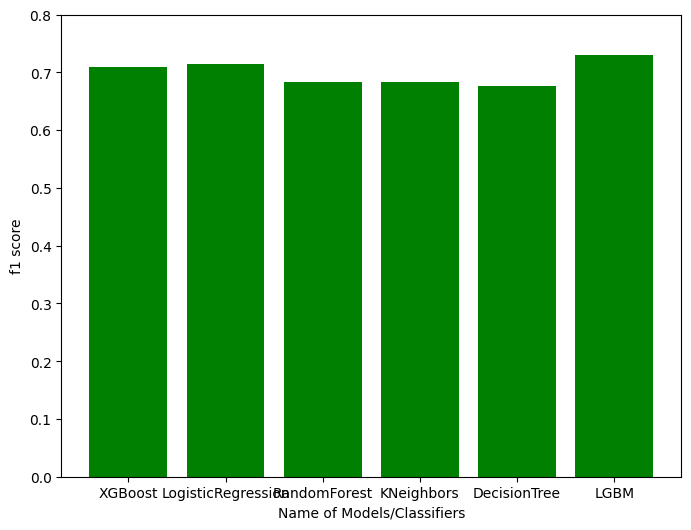

In [45]:
#Plotting f1_scores by each model for comparison

model_list = ['XGBoost', 'LogisticRegression', 'RandomForest', 'KNeighbors', 'DecisionTree', 'LGBM']
f1_score_list = [xgc_f1, lrc_f1, rfc_f1, knc_f1, dtc_f1, lgc_f1]

plt.figure(figsize=(8,6))
plt.bar(model_list, f1_score_list, color = 'green')
plt.xlabel('Name of Models/Classifiers')
plt.ylabel('f1 score')
plt.ylim(0,0.8)
plt.show()

#### Insights

From the graph we observe that LGBMClassifier has the greatest while DecisionTreeClassifier has the lowest f1 score.

## -> Precision

In [46]:
#Calculating precision scores by each model used

xgc_p = precision_score(Y_valid, xgc_pred, average = 'weighted')   
lrc_p = precision_score(Y_valid, lrc_pred, average = 'weighted')
rfc_p = precision_score(Y_valid, rfc_pred, average = 'weighted')
knc_p = precision_score(Y_valid, knc_pred, average = 'weighted')
dtc_p = precision_score(Y_valid, dtc_pred, average = 'weighted')
lgc_p = precision_score(Y_valid, lgc_pred, average = 'weighted')

print(f"The precision score by XGBClassifier is {xgc_p}, LogisticRegressionClassifier is {lrc_p}, RandomForestClassifier is {rfc_p}, KNeighborsClassifier is {knc_p}, DecisionTreeClassifier is {dtc_p} and LGBMClassifier is {lgc_p}")

The precision score by XGBClassifier is 0.7139459762606237, LogisticRegressionClassifier is 0.7116563453594978, RandomForestClassifier is 0.7806356488292481, KNeighborsClassifier is 0.6557864722586114, DecisionTreeClassifier is 0.6680083011138259 and LGBMClassifier is 0.7314254693838034


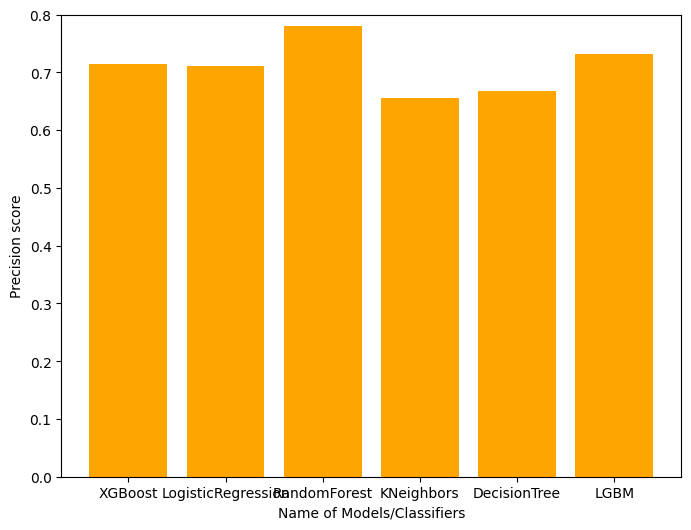

In [48]:
#Plotting precision scores by each model for comparison

model_list = ['XGBoost', 'LogisticRegression', 'RandomForest', 'KNeighbors', 'DecisionTree', 'LGBM']
precision_list = [xgc_p, lrc_p, rfc_p, knc_p, dtc_p, lgc_p]

plt.figure(figsize=(8,6))
plt.bar(model_list, precision_list, color = 'orange')
plt.xlabel('Name of Models/Classifiers')
plt.ylabel('Precision score')
plt.ylim(0,0.8)
plt.show()

#### Insights

From the graph we observe that RandomForestClassifier has the greatest while KNeighborsClassifier has the lowest precision score.

## -> Accuracy

In [49]:
#Calculating accuarcy scores by each model used

xgc_a = accuracy_score(Y_valid, xgc_pred)   
lrc_a = accuracy_score(Y_valid, lrc_pred)
rfc_a = accuracy_score(Y_valid, rfc_pred)
knc_a = accuracy_score(Y_valid, knc_pred)
dtc_a = accuracy_score(Y_valid, dtc_pred)
lgc_a = accuracy_score(Y_valid, lgc_pred)

print(f"The accuracy score by XGBClassifier is {xgc_a}, LogisticRegressionClassifier is {lrc_a}, RandomForestClassifier is {rfc_a}, KNeighborsClassifier is {knc_a}, DecisionTreeClassifier is {dtc_a}, and LGBMClassifier is {lgc_a}")

The accuracy score by XGBClassifier is 0.7749266862170088, LogisticRegressionClassifier is 0.7767595307917888, RandomForestClassifier is 0.7719941348973607, KNeighborsClassifier is 0.7382697947214076, DecisionTreeClassifier is 0.6862170087976539, and LGBMClassifier is 0.781891495601173


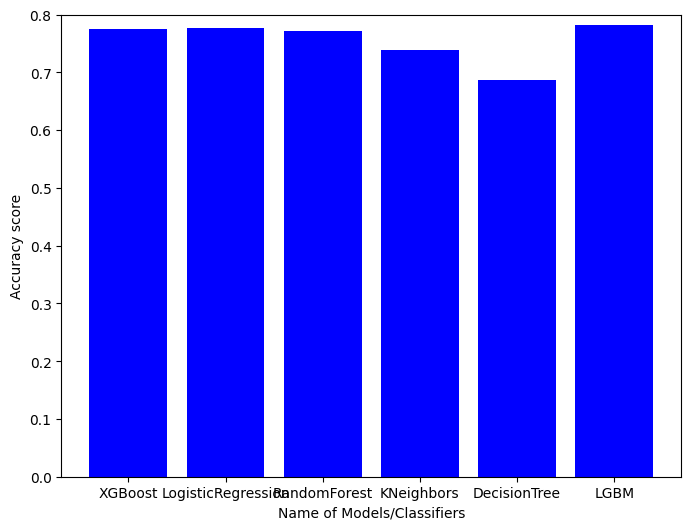

In [50]:
#Plotting accuracy scores by each model for comparison

model_list = ['XGBoost', 'LogisticRegression', 'RandomForest', 'KNeighbors', 'DecisionTree', 'LGBM']
accuracy_list = [xgc_a, lrc_a, rfc_a, knc_a, dtc_a, lgc_a]

plt.figure(figsize=(8,6))
plt.bar(model_list, accuracy_list, color = 'blue')
plt.xlabel('Name of Models/Classifiers')
plt.ylabel('Accuracy score')
plt.ylim(0,0.8)
plt.show()

#### Insights

From the graph we observe that LGBMClassifier has the greatest while DecisionTree has the lowest accuracy score.

## -> Classification Report

In [51]:
#Classification report for XGBoostClassifier:

print(classification_report(Y_valid, xgc_pred))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18       255
           1       0.38      0.19      0.25        32
           2       0.40      0.06      0.10        34
           3       0.46      0.17      0.25        65
           4       0.44      0.08      0.14       262
           5       0.79      0.98      0.88      2080

    accuracy                           0.77      2728
   macro avg       0.49      0.26      0.30      2728
weighted avg       0.71      0.77      0.71      2728



In [52]:
#Classification report for LogisticRegressionClassifier:

print(classification_report(Y_valid, lrc_pred))

              precision    recall  f1-score   support

           0       0.52      0.16      0.25       255
           1       0.35      0.19      0.24        32
           2       0.20      0.03      0.05        34
           3       0.31      0.06      0.10        65
           4       0.42      0.09      0.15       262
           5       0.80      0.98      0.88      2080

    accuracy                           0.78      2728
   macro avg       0.43      0.25      0.28      2728
weighted avg       0.71      0.78      0.71      2728



In [53]:
#Classification report for RandomForestClassifier:

print(classification_report(Y_valid, rfc_pred))

              precision    recall  f1-score   support

           0       0.75      0.05      0.09       255
           1       0.50      0.03      0.06        32
           2       1.00      0.06      0.11        34
           3       1.00      0.05      0.09        65
           4       0.83      0.04      0.07       262
           5       0.77      1.00      0.87      2080

    accuracy                           0.77      2728
   macro avg       0.81      0.20      0.22      2728
weighted avg       0.78      0.77      0.68      2728



In [54]:
#Classification report for KNeighborsClassifier:

print(classification_report(Y_valid, knc_pred))

              precision    recall  f1-score   support

           0       0.32      0.12      0.18       255
           1       0.25      0.16      0.19        32
           2       0.14      0.06      0.08        34
           3       0.33      0.05      0.08        65
           4       0.13      0.05      0.07       262
           5       0.79      0.94      0.86      2080

    accuracy                           0.74      2728
   macro avg       0.33      0.23      0.24      2728
weighted avg       0.66      0.74      0.68      2728



In [55]:
#Classification report for DecisionTreeClassifier:

print(classification_report(Y_valid, dtc_pred))

              precision    recall  f1-score   support

           0       0.19      0.18      0.18       255
           1       0.27      0.25      0.26        32
           2       0.10      0.06      0.07        34
           3       0.17      0.17      0.17        65
           4       0.22      0.18      0.19       262
           5       0.81      0.85      0.83      2080

    accuracy                           0.69      2728
   macro avg       0.29      0.28      0.29      2728
weighted avg       0.67      0.69      0.68      2728



In [56]:
#Classification report for LGBMClassifier:

print(classification_report(Y_valid, lgc_pred))

              precision    recall  f1-score   support

           0       0.52      0.18      0.27       255
           1       0.56      0.16      0.24        32
           2       0.60      0.09      0.15        34
           3       0.41      0.20      0.27        65
           4       0.46      0.14      0.21       262
           5       0.81      0.98      0.88      2080

    accuracy                           0.78      2728
   macro avg       0.56      0.29      0.34      2728
weighted avg       0.73      0.78      0.73      2728



## -> Confusion Matrix

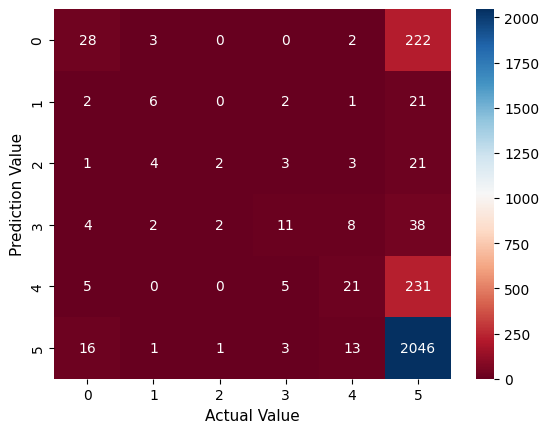

In [57]:
#Displaying Confusion Matrix for XGBClassifier:

cm = confusion_matrix(Y_valid, xgc_pred)
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels=sorted(labels), yticklabels=sorted(labels), cmap='RdBu')
plt.ylabel('Prediction Value', fontsize=11)
plt.xlabel('Actual Value', fontsize=11)
plt.show()

#### Insights

From the above confusion matrix it can be interpreted that:

- The model performs well in correctly predicting class 0 and class 5.

- However, there are significant misclassifications, for class 5 as well.

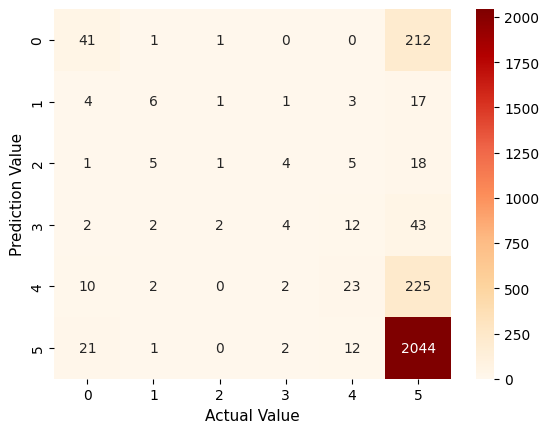

In [58]:
#Displaying Confusion Matrix for LogisticRegressionClassifier:

cm = confusion_matrix(Y_valid, lrc_pred)
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels = sorted(labels), yticklabels = sorted(labels), cmap = "OrRd")
plt.ylabel('Prediction Value', fontsize=11)
plt.xlabel('Actual Value', fontsize=11)
plt.show()

#### Insights

From the above confusion matrix it can be interpreted that:

- The model performs well in correctly predicting class 0, class 4 and class 5.

- However, there are significant misclassifications for Class 5 as well.

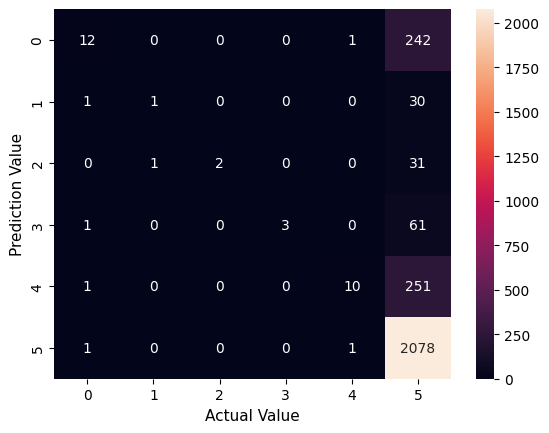

In [59]:
#Displaying Confusion Matrix for RandomForestClassifier:

cm = confusion_matrix(Y_valid, rfc_pred)
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels = sorted(labels), yticklabels = sorted(labels))
plt.ylabel('Prediction Value', fontsize=11)
plt.xlabel('Actual Value', fontsize=11)
plt.show()

#### Insights

From the above confusion matrix it can be interpreted that:

- The model performs well in correctly predicting class 0 and class 5, but class 5 is often misclassified as other classes too.

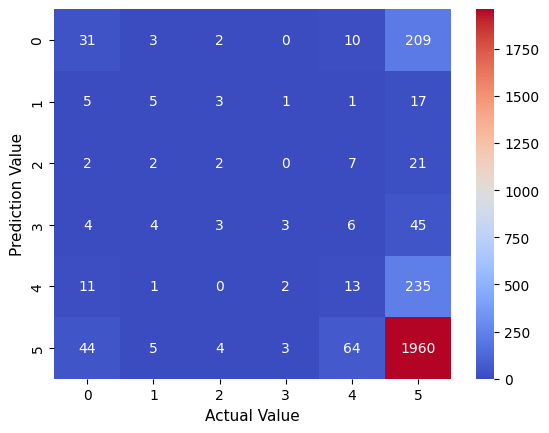

In [60]:
#Displaying Confusion Matrix for KNeighborsClassifier:

cm = confusion_matrix(Y_valid, knc_pred)
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels = sorted(labels), yticklabels = sorted(labels), cmap='coolwarm')
plt.ylabel('Prediction Value', fontsize=11)
plt.xlabel('Actual Value', fontsize=11)
plt.show()

#### Insights

From the above confusion matrix it can be interpreted that:

- The model performs well in correctly predicting class 5.

- However, there are significant misclassifications, such as, Class 0 is often misclassified as other classes.

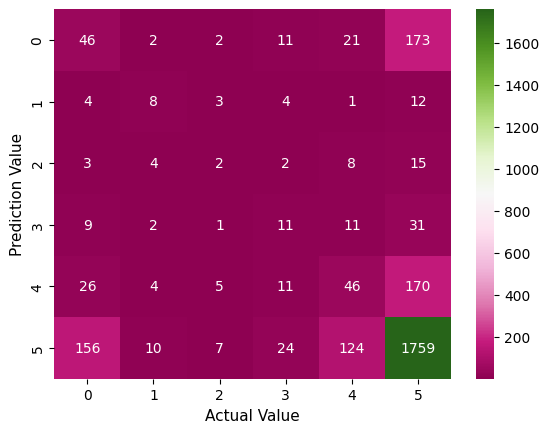

In [61]:
#Displaying Confusion Matrix for DecisionTreeClassifier:

cm = confusion_matrix(Y_valid, dtc_pred)
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels = sorted(labels), yticklabels = sorted(labels), cmap='PiYG')
plt.ylabel('Prediction Value', fontsize=11)
plt.xlabel('Actual Value', fontsize=11)
plt.show()

#### Insights

From the above confusion matrix it can be interpreted that:

- The model performs well in correctly predicting class 5.

- However, there are significant misclassifications, such as, Class 5, Class 4 and Class 0 are often misclassified as other classes.

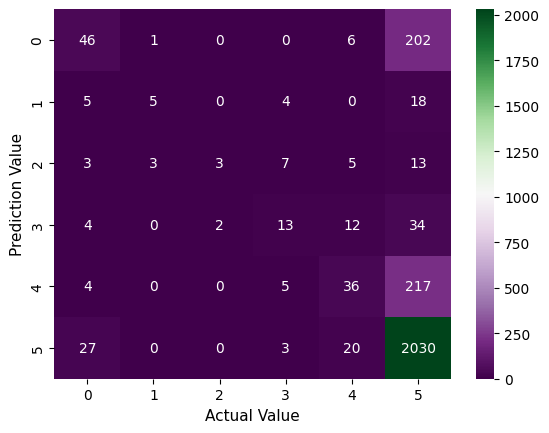

In [62]:
#Displaying Confusion Matrix for LGBMClassifier:

cm = confusion_matrix(Y_valid, lgc_pred)
sns.heatmap(cm, annot = True, fmt = 'g', xticklabels = sorted(labels), yticklabels = sorted(labels), cmap='PRGn')
plt.ylabel('Prediction Value', fontsize=11)
plt.xlabel('Actual Value', fontsize=11)
plt.show()

#### Insights

From the above confusion matrix it can be interpreted that:

- The model performs well in correctly predicting class 5.


# Prediction on Test Dataset

As we could see during the model training baove, the best accuracy score was given by LGBMClassifier, so for prediction on test dataset, we will use model6 i.e LGBM

In [63]:
predictions = model6.predict(np.asarray(X_transformed_test))

# Creating Submission File

In [64]:
submission_df = pd.DataFrame({'ID': range(1,len(predictions)+1), 'Rating': predictions})
submission_df

,ID,Rating
0,1,5
1,2,5
2,3,5
3,4,3
4,5,5
...,...,...
4541,4542,5
4542,4543,5
4543,4544,5
4544,4545,1


In [65]:
submission_df.to_csv('submission.csv', index=False)